# Evaluate model
Takes a model and creates a pandas file which sumarizes the behavior of the model

## Check if Colab

In [34]:
import os
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("Is in Colab: ", IN_COLAB)
if IN_COLAB:
    os.system('git clone https://github.com/AllaVinner/JL-ML.git')
    os.system('pip install -e JL-ML')
    # Needed for colab to find the JL-ML directory
    import site
    site.main()

saved_path   = os.path.join('..','saved-models') if not IN_COLAB else  os.path.join('JL-ML','saved-models')

Is in Colab:  False


In [35]:
import yaml
import os
import keras

import pandas as pd
import numpy as np
import tensorflow as tf

from os.path import join
from sklearn.manifold import TSNE

from jlauto.models.variational_autoencoder import VariationalAutoencoder
from jlauto.models.autoencoder import Autoencoder
from jlauto.models.continuous_bernoulli_loss import continuous_bernoulli_loss


In [36]:
model_name = 'vae_rf_10000'

In [37]:
# Get config
model_path = join(saved_path, model_name)
# Read YAML file
with open(join(model_path, 'config.yaml'), 'r') as stream:
    config = yaml.safe_load(stream)

In [38]:
# Load model
if config['model_type'] == "autoencoder":
    model = keras.models.load_model(model_path, 
                custom_objects={"Autoencoder": Autoencoder,
                                 "continuous_bernoulli_loss": continuous_bernoulli_loss})
elif config['model_type'] == "variational_autoencoder":
    model = keras.models.load_model(model_path, 
                custom_objects={"VariationalAutoencoder": VariationalAutoencoder,
                                "continuous_bernoulli_loss":  continuous_bernoulli_loss})
  

# Get test data

In [39]:
(_, _), (test_digits, test_labels) = keras.datasets.mnist.load_data()
test_digits = np.expand_dims(test_digits, -1).astype("float32") / 255
input_shape = test_digits.shape[1:]
num_test = test_labels.shape[0]

In [40]:
# Encode digits
if config['model_type'] == "autoencoder":
        code = model.encoder(test_digits).numpy()
        code_std = np.empty(shape = code.shape)*np.nan
        
elif config['model_type'] == "variational_autoencoder":
        digit_distribution = model.encoder(test_digits).numpy()
        code = digit_distribution[:,0,:]
        code_std = np.sqrt(np.exp(digit_distribution[:,1,:]))
    
# Caclualte latent data
latent_distance = np.linalg.norm(code, axis = 1) # code distance from origo
latent_radius = np.power(np.prod(code_std, axis = 1),1/config['latent_dim']) # code's average radius 
latent_loss = tf.reduce_mean(tf.reduce_mean(tf.keras.losses.binary_crossentropy(test_digits, model(test_digits)),axis = -1),axis = -1).numpy()
latent_tsne = TSNE(n_components = 2).fit_transform(code)

latent_df = pd.DataFrame(data = {
    'model_name' : config['name'],
    'label' : test_labels,
    'loss' : latent_loss,
    'distance' : latent_distance,
    'radius' : latent_radius,
    'X' : code[:,0],
    'Y': code[:,1],
    'tsne_0' : latent_tsne[:,0],
    'tsne_1' : latent_tsne[:,1],
}) 


# Calculate dimension_df data
dim_std = np.nanstd(code, axis = 0)
dim_radius = np.nanmean(code_std, axis = 0)
dim_index = np.arange(config['latent_dim'])

dimension_df = pd.DataFrame(data = {
    'model_name' : config['name'],
    'dim_index' : dim_index,
    'code_spread' : dim_std,
    'mean_radius' : dim_radius,
})



C:\Users\joelw\miniconda3\envs\jenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\joelw\miniconda3\envs\jenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [41]:
latent_df.head()

,model_name,label,loss,distance,radius,X,Y,tsne_0,tsne_1
0,vae_rf_10000,7,0.113947,3.742115,0.015228,0.408795,3.719719,22.215065,80.876228
1,vae_rf_10000,2,0.277838,0.254967,0.007645,0.224154,-0.121504,35.775917,-17.381382
2,vae_rf_10000,1,0.040716,3.603954,0.013588,-2.767106,2.309027,-63.880718,64.193726
3,vae_rf_10000,0,0.159851,1.239823,0.008411,-0.667695,-1.044674,46.241421,-63.043285
4,vae_rf_10000,4,0.157673,1.887189,0.013515,1.591331,1.014468,50.704559,12.073505


In [42]:
dimension_df.head()

,model_name,dim_index,code_spread,mean_radius
0,vae_rf_10000,0,1.095071,0.012464
1,vae_rf_10000,1,1.368258,0.011613


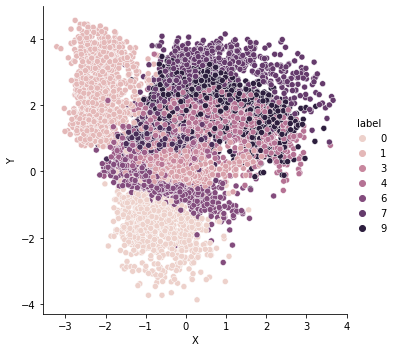

In [43]:
import seaborn as sns
sns.relplot(data = latent_df, x = 'X', y='Y', hue = 'label')

## Save data frames

In [44]:
latent_df.to_csv(join(saved_path,model_name,'latent_df.csv'), index=False)
dimension_df.to_csv(join(saved_path,model_name,'dimension_df.csv'), index=False)